### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [1]:
# libraries
import os
import sys
import platform
print(sys.version)

in_colab = 'google.colab' in sys.modules
strong_pc = platform.system() == 'Linux'

if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'data', 'ESC-10-depth')
samplerate = 44100

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.12.0
keras version = 2.10.0


# 3 UNSUPERVISED LEARNING: AUTOENCODERS

In [2]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

## 3.3 Autoencoder on preprocessed audio - Convolutional and flatten code

As we have seen before the MEL preprocessing is always beaten by one of the other two. For this reason we are going to avoid this type of computations and we will train the autoencoder to reconstruct the MFCC or the STFT only.

### Create the dataset

In [3]:
preprocessing = 'MFCC'
AE_name = 'AE_Conv_prep_flatten_'+preprocessing
train, val, test, INPUT_DIM = create_US_dataset(
        preprocessing=preprocessing,
        folder_number=1,
        main_dir = main_dir,
)

Creating the dataset from folder 01


In [4]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [ AE_name+'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created AE_Conv_prep_flatten_MFCC_count.txt with content '0' in folder Saved_Models


To interpret the mean squared error the we are going to optimize in our training we need to compute some mse between our images and some random images or between couple of images in our training set.

In [5]:
mse = tf.keras.losses.MeanSquaredError()

# Extract the first batch from the training set: x is a tuple of arrays of dim (128,220500)
for x, y in train.take(1):
    #compute the mse between the first batch and a batch of random images with the same shape
    random_images_1 = tf.random.uniform(shape=x.shape, minval = -1, maxval = 1,dtype=tf.float32)
    random_images_2 = np.random.uniform(-1, 1, size = x.shape)
    print(f'Mean MSE between an audio preprocessed and a random image (tf) : {mse(x, random_images_1):.5f}')
    print(f'Mean MSE between an audio preprocessed and a random image (np): {mse(x, random_images_2):.5f}')
    print(f'Mean MSE between two random images (tf-np): {mse(random_images_1, random_images_2):.5f}')

Mean MSE between an audio preprocessed and a random image (tf) : 0.33833
Mean MSE between an audio preprocessed and a random image (np): 0.33878
Mean MSE between two random images (tf-np): 0.66618


### Preparation to use Keras-Tuner

Now we define a function to build a generic convolutional autoencoder. We'll give this function to a keras tuner.

In [6]:
#General function to build an autoencoder
#CONVOLUTIONAL AUTOENCODER WITH VECTORIAL CODE
code_size = 32
n_layers = 2
n_units = 32

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_size = code_size,
                      activation = 'tanh',
                      padding = 'valid',
                      n_layers = n_layers, #max number of layers is 3
                      n_units = n_units,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name
 ):
    lr = learning_rate
    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))
    for i in range(n_layers):
        encoder.add(layers.Conv2D(n_units * (i+1), kernel_size,strides = strides, activation = activation, padding=padding))
        encoder.add(layers.MaxPool2D(max_pooling, padding='same'))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    # flatten layer to get the code
    my_shape = encoder.layers[-1].output_shape
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size,activation = activation, activity_regularizer=keras.regularizers.l1(regularizer)))

    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(code_size))
    decoder.add(layers.Dense(np.prod(my_shape[1:]), activation=activation))
    decoder.add(layers.Reshape(my_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):
        filters = n_units * (n_layers-i) if i<n_layers-1 else 1
        decoder.add(layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, padding=padding))
        decoder.add(layers.UpSampling2D(size=max_pooling))
        if batch_norm:
            decoder.add(layers.BatchNormalization())

    #final reshape
    decoder.add(tf.keras.layers.Resizing(height = INPUT_DIM[0], width = INPUT_DIM[1], interpolation="bilinear", crop_to_aspect_ratio=False))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [7]:
verbose = 0
#test the build_autoencoder function
autoencoder = build_autoencoder(n_layers = 3)
if verbose > 1:
    autoencoder.summary(line_length=100)
    autoencoder.layers[1].summary(line_length=100)
    autoencoder.layers[2].summary(line_length=100)


Model built with 226403 trainable params


In [8]:
# function to build the model using different hyperparameters (keras tuner code)
def build_model(hp,test=False):

    #define hyperparameters
    if test: #if test is true you run the tuner only on a reduced hyperparameter space
        print('Running a test smaller grid search')
        n_units = 32
        n_layers = hp.Choice(name = 'n_layers', values =  [2,3])
        kernel_size = 3
        strides = 2
        max_pooling = 2
        regularizer = hp.Choice(name = 'regularizer', values = [1e-4,0.0])
        padding = 'same'
        code_size = 32
        activation = 'tanh'
        drop_out = hp.Choice(name = 'drop_out', values = [0.25,0.0])
        batch_norm = True
        lr_max, lr_min = 1e-3, 1e-3
        hp_lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')
    else:
        n_units = hp.Choice(name = 'n_units', values =  [4,8,16,32,64,128], default = 32)
        n_layers = hp.Int(name = 'n_layers', min_value = 1, max_value = 3, step=1, sampling='linear', default = 2)
        kernel_size = hp.Choice(name = 'kernel_size', values = [3,5,7], default = 3)
        strides = hp.Choice(name = 'strides', values = [1,2,3], default = 2)
        max_pooling = hp.Choice(name = 'max_pooling' , values = [2,3,4], default = 2)
        regularizer = hp.Choice(name = 'regularizer', values = [0.0,1e-2,1e-3,1e-4,1e-5], default = 1e-4)
        padding = hp.Choice(name = 'padding', values = ['same','valid'], default = 'valid')
        code_size = hp.Choice(name = 'code_size', values = [2,10,32,128], default = 32)
        activation = hp.Choice(name = 'activation', values = ['relu','elu','tanh'], default = 'tanh')
        drop_out = hp.Choice(name = 'drop_out', values = [0.0, 0.25, 0.5], default = 0.0)
        batch_norm = hp.Choice(name = 'batch_norm', values = [True, False], default = True)
        lr_min, lr_max =1e-4, 1e-1
        learning_rate= hp.Choice('learning_rate', values = [1e-4, 1e-3, 5*1e-3, 1e-2,5*1e-2,1e-1], default = 1e-3)


    model = build_autoencoder(code_size = code_size,
                              activation = activation,
                              padding = padding,
                              n_layers = n_layers,
                              n_units = n_units,
                              kernel_size = (kernel_size,kernel_size),
                              strides = (strides,strides),
                              max_pooling = (max_pooling, max_pooling),
                              regularizer = regularizer,
                              batch_norm = batch_norm,
                              drop_out = drop_out,
                              learning_rate= learning_rate)

    return model


In [9]:
#test the build_model function
build_model(kt.HyperParameters()).summary()

Model built with 189795 trainable params
Model: "AE_Conv_prep_flatten_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                84768     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        105349    
                                                                 
Total params: 190,117
Trainable params: 189,795
Non-trainable params: 322
_________________________________________________________________


### Implement the grid search hyperparamter-wise

In [11]:
# dictionary with the default values of the hyperparams to be update each time
default_values = {
    'n_layers': 2,
    'n_units': 32,
    'kernel_size': 3,
    'strides':2,
    'max_pooling':2,
    'regularizer':0.0,
    'padding':'valid',
    'code_size':32,
    'activation':'tanh',
    'drop_out':0.0,
    'batch_norm':True,
    'learning_rate':1e-3
}

key_list = list(default_values.keys())

#define the general variables for our tuner
hpo_methods = ['RandomSearch', 'BayesianOptimization','Hyperband']
problematic_combination = []
max_model_size = 10**6
max_trials = 10
dir_name = 'Conv_AE_flatten_code_'+preprocessing
verbose=3

if strong_pc:
    train_small = train
    val_small = val
else:
    small_size_dataset = 40
    train_val_small = train.unbatch().take(small_size_dataset)
    train_small = train_val_small.skip(10).batch(25)
    val_small = train_val_small.take(10).batch(25)

# define a list to collect all the best scores
best_score_dict ={
    'RandomSearch': [],
    'BayesianOptimization': [],
    'Hyperband': []
}

#to be consistent with this type of grd search we should pass each hp more than one time...
for hpo_method in hpo_methods:
    random.shuffle(key_list)
    for hyper_params in key_list:
        print(f'Searching for the best value for {hyper_params}')

        #define an hp set with all fix but one
        hp = kt.HyperParameters()

        for fixed_param in default_values.keys():
            if fixed_param != hyper_params:
                hp.Fixed(name = fixed_param, value = default_values[fixed_param])

        if verbose>1:
            display(hp.space)

        try:
            #create a tuner for the params not fixed
            tuner = build_tuner(build_model = build_model,
                                hpo_method = hpo_method,
                                max_model_size = max_model_size,
                                max_trials = max_trials,
                                dir_name = dir_name,
                                overwrite = True,
                                objective = kt.Objective('val_mse', direction='min'),
                                hp=hp,
                                not_fixed_param = hyper_params,
                                tune_new_entries=True
                                )

            if verbose>2:
                display(tuner.search_space_summary(extended = True))

            #fit the tuner
            epochs = 1#50
            patience = 10
            metrics = ['mse']
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                        verbose=verbose,
                                                        patience=patience)]

            tuner.search(train_small, validation_data = val_small,
                                callbacks=callbacks,
                                epochs=epochs,
                                verbose=int(verbose>0),
                        )

            #retrive the best value for the free hp
            best_value = tuner.get_best_hyperparameters()[0].values[hyper_params]

            #retrive the best score reached
            best_score = tuner.get_best_models(num_models=1)[0].evaluate(val, return_dict = True)['mse']
            #The models are loaded with the weights corresponding to their best checkpoint (at the end of the best epoch of best trial).
            #altrernatively
            #best_score = tuner.load_model(tuner.oracle.get_best_trials(num_trials=1)[0]).evaluate(val, return_dict=True)['mse']

            print(f'The best value for {hyper_params} is {best_value}, the best score is {best_score}')
            best_score_dict[hpo_method].append(best_score)

            #update the default dict of values
            default_values[hyper_params] = best_value

            #save the updated dictionary
            file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
            with open(file_path, 'wb') as file:
                pickle.dump(default_values, file)

            #delete the folder just created by the run
            shutil.rmtree(os.path.join(main_dir,dir_name, hpo_method+'_'+hyper_params))

        except:
            problematic_combination.append(('search_for'+hyper_params, default_values))

    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)

    display(best_params)

#save the best_score_dict
file_path = os.path.join(main_dir, dir_name, 'best_scores'+preprocessing)
with open(file_path, 'wb') as file:
    pickle.dump(best_score_dict, file)

with open(file_path, 'rb') as file:
    best_scores = pickle.load(file)

display(best_scores)

display(problematic_combination)

Trial 6 Complete [00h 00m 12s]
val_mse: 0.005060477182269096

Best val_mse So Far: 0.004866231232881546
Total elapsed time: 00h 01m 02s
INFO:tensorflow:Oracle triggered exit
Model built with 381587 trainable params
2/2 [==============================] - 3s 388ms/step - loss: 0.0078 - mse: 0.0070
The best value for n_units is 16, the best score is 0.007031549699604511


{'n_layers': 3,
 'n_units': 16,
 'kernel_size': 3,
 'strides': 1,
 'max_pooling': 2,
 'regularizer': 0.001,
 'padding': 'valid',
 'code_size': 32,
 'activation': 'tanh',
 'drop_out': 0.5,
 'batch_norm': 1,
 'learning_rate': 0.001}

{'RandomSearch': [],
 'BayesianOptimization': [],
 'Hyperband': [0.0074576945044100285,
  0.007443343289196491,
  0.007385160308331251,
  0.007417250424623489,
  0.007347583770751953,
  0.006991904694586992,
  0.007098549976944923,
  0.007010047789663076,
  0.00712982751429081,
  0.0069526382721960545,
  0.006936909165233374,
  0.007031549699604511]}

[]

In [ ]:
# compare the best hp from the 3 grid search methods
hyperparamters = []
for hpo_method in  ['RandomSearch', 'BayesianOptimization','Hyperband']:
    file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
    with open(file_path, 'rb') as file:
        hyperparamters.append(pickle.load(file))
pd.DataFrame(hyperparamters, index = ['RandomSearch', 'BayesianOptimization','Hyperband'])

,n_layers,n_units,kernel_size,strides,max_pooling,regularizer,padding,code_size,activation,drop_out,batch_norm,learning_rate
RandomSearch,2,32,3,2,2,0.0,valid,10,tanh,0.0,True,0.001
BayesianOptimization,2,32,3,2,2,0.0,valid,10,tanh,0.0,0,0.001
Hyperband,2,32,3,2,3,0.0,valid,10,tanh,0.0,0,0.001


In [ ]:
file_path = os.path.join(main_dir, dir_name, 'Hyperband'+'_best_params')
with open(file_path, 'rb') as file:
    ummm = pickle.load(file)
display(type(ummm))

dict

### Train the model with the best params on more data

Model built with 67083 trainable params
Model: "AE_Conv_prep_flatten"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 10)                23946     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        43137     
                                                                 
Total params: 67,083
Trainable params: 67,083
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 0
Creating the dataset from folder 01
Create the dataset with 2000 files requires 0.6 seconds.


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\AE_Conv_prep_flatten_MFCC\assets


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\AE_Conv_prep_flatten_MFCC\assets


Best epoch: 1


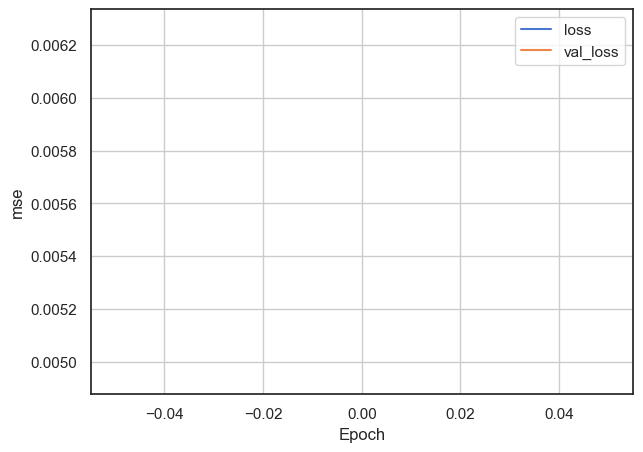

2/2 [==============================] - 1s 116ms/step - loss: 0.0063 - mse: 0.0063


[0.006285047624260187, 0.006285047624260187]

This model has a size of 0.8200149536132812 MB
Creating the dataset from folder 02
dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
dataset type <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Create the dataset with 2000 files requires 434.01 seconds.


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\AE_Conv_prep_flatten_MFCC\assets


INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\AE_Conv_prep_flatten_MFCC\assets


Best epoch: 1


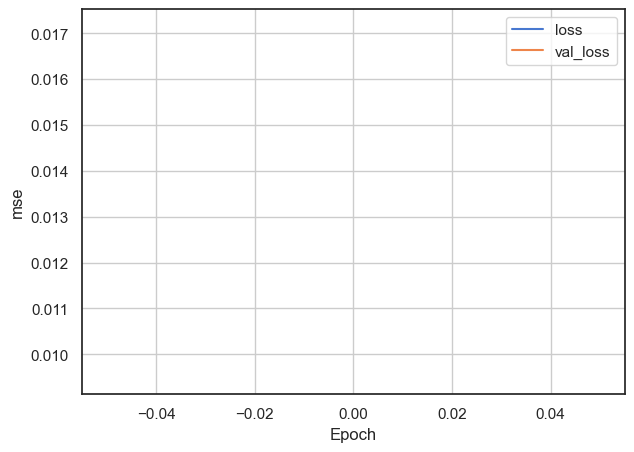

2/2 [==============================] - 0s 88ms/step - loss: 0.0098 - mse: 0.0098


[0.009756151586771011, 0.009756151586771011]

This model has a size of 0.8200149536132812 MB


In [ ]:
insert_by_hand = False

if insert_by_hand:
    best_params = {
        'n_layers':1,
        'n_units':64,
        'kernel_size':3,
        'strides':3,
        'max_pooling':3,
        'regularizer':0.0001,
        'padding':'valid',
        'code_size':128,
        'activation':'elu',
        'drop_out':0.25,
        'batch_norm':False,
        'learning_rate':0.00175,
    }
else:
    file_path = os.path.join(main_dir, dir_name, 'Hyperband'+'_best_params')
    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)


# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

epochs = 1 if not strong_pc else 100
n_folders = 2 if not strong_pc else 50 #then you can restart and train on more folders

US_training(AE_name = AE_name, autoencoder = autoencoder, epochs = epochs , n_folders=n_folders, preprocessing = preprocessing, ndim=3)

### Show the reconstruction capabilities of the model

Model: "AE_Conv_prep_flatten"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 10)                23946     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        43137     
                                                                 
Total params: 67,083
Trainable params: 67,083
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 64ms/step


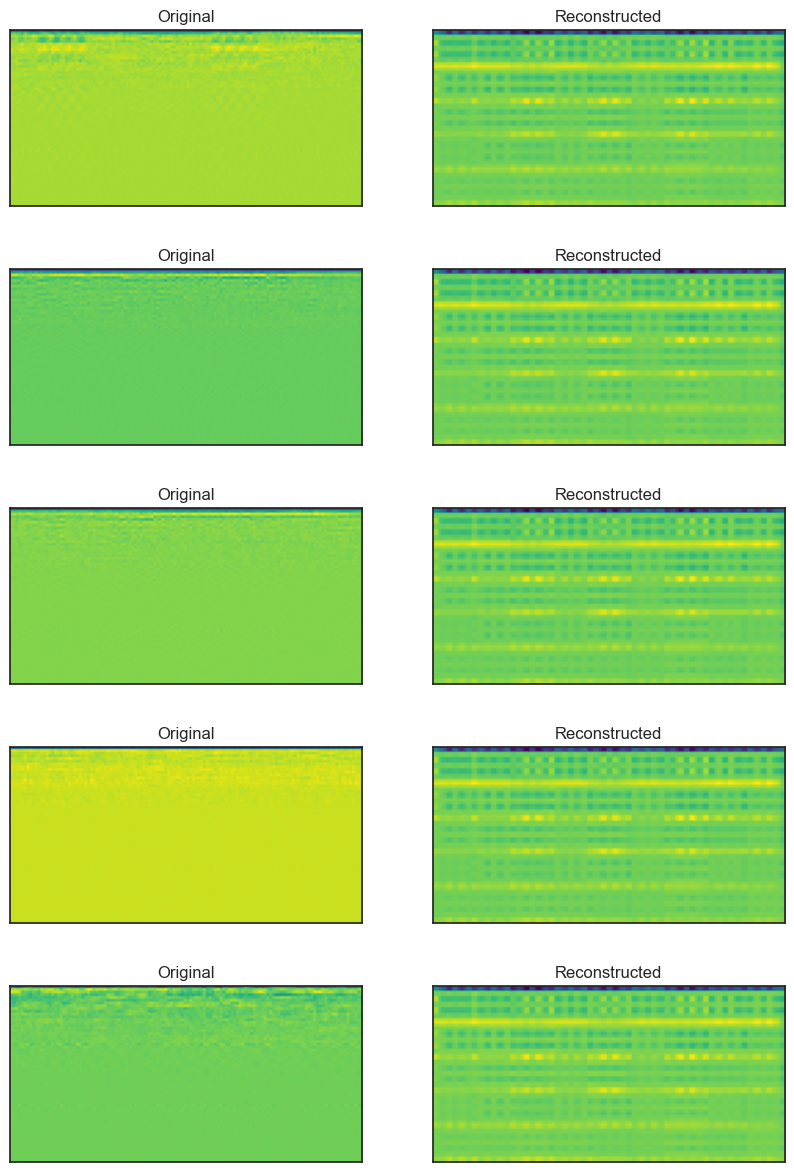

In [ ]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)